In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.ensemble import VotingClassifier

**Task - 1** Data Loading and Exploration

In [62]:
#load dataset
df = pd.read_csv("/dataset.csv")

In [63]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
#sample size
df.shape[0]

42000

In [65]:
#class distribution
df['label'].value_counts().sort_index()

,count
label,
0,4132
1,4684
2,4177
3,4351
4,4072
5,3795
6,4137
7,4401
8,4063


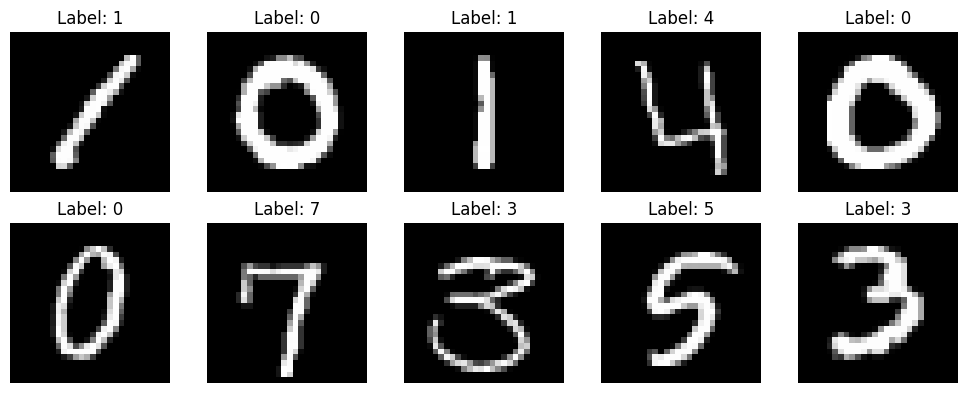

In [66]:
#Sample images with their labels
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

plt.figure(figsize=(10,4))

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(X[i].reshape(28,28),cmap = "gray")
  plt.title(f"Label: {y[i]}")
  plt.axis("off")

plt.tight_layout()
plt.show()

In [67]:
df.isna().sum().sum() #no missing values

np.int64(0)

**Task-2** Data Preprocessing

In [68]:
#normalize pixel values
X = X.astype("float32")/255.0

In [69]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

In [70]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33600, 784) (33600,)
(8400, 784) (8400,)


In [71]:
#pca
pca = PCA(n_components = 0.95, random_state = 42)

In [86]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [87]:
print(X_train_pca.shape)
print(X_test_pca.shape)

(33600, 153)
(8400, 153)


**Task - 3** Model Implementation

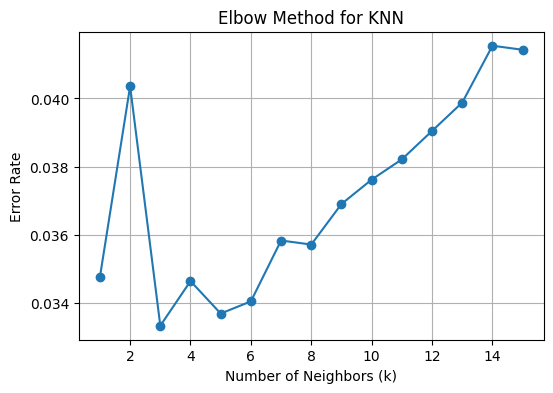

In [74]:
#elbow method for optimal k value
k_values = range(1, 16)
errors = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    error = 1 - accuracy_score(y_test, preds)
    errors.append(error)

plt.figure(figsize=(6,4))
plt.plot(k_values, errors, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Error Rate")
plt.title("Elbow Method for KNN")
plt.grid(True)
plt.show()

In [78]:
#KNN with k = 3
knn_raw = KNeighborsClassifier(n_neighbors=3)
knn_raw.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [79]:
y_pred_knn_raw = knn_raw.predict(X_test)

In [80]:
acc_knn_raw = accuracy_score(y_test, y_pred_knn_raw)
print(acc_knn_raw)

0.9666666666666667


In [81]:
#KNN with PCA features
knn_pca = KNeighborsClassifier(n_neighbors=3)
knn_pca.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=3)

In [88]:
y_pred_knn_pca = knn_pca.predict(X_test_pca)

In [89]:
acc_knn_pca = accuracy_score(y_test, y_pred_knn_pca)
print(acc_knn_pca)

0.968452380952381


In [91]:
#SVM - tuning c and gamma values
C_values = [1, 10]
gamma_values = ["scale", 0.01, 0.001]

best_acc = 0
best_params = None

for C in C_values:
    for gamma in gamma_values:
        svm = SVC(kernel="rbf", C=C, gamma=gamma)
        svm.fit(X_train, y_train)
        preds = svm.predict(X_test)
        acc = accuracy_score(y_test, preds)

        print(f"C={C}, gamma={gamma} → accuracy={acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_params = (C, gamma)

print("Best parameters:", best_params)
print("Best accuracy:", best_acc)

C=1, gamma=scale → accuracy=0.9742
C=1, gamma=0.01 → accuracy=0.9708
C=1, gamma=0.001 → accuracy=0.9310
C=10, gamma=scale → accuracy=0.9792
C=10, gamma=0.01 → accuracy=0.9782
C=10, gamma=0.001 → accuracy=0.9488
Best parameters: (10, 'scale')
Best accuracy: 0.9791666666666666


In [92]:
#SVM
best_C, best_gamma = best_params

svm_raw = SVC(
    kernel="rbf",
    C=best_C,
    gamma=best_gamma
)

svm_raw.fit(X_train, y_train)

SVC(C=10)

In [93]:
y_pred_svm_raw = svm_raw.predict(X_test)

In [94]:
acc_svm_raw = accuracy_score(y_test, y_pred_svm_raw)
print("Final SVM (raw) accuracy:", acc_svm_raw)

Final SVM (raw) accuracy: 0.9791666666666666


In [95]:
C_values = [1, 10]
gamma_values = ["scale", 0.01, 0.001]

best_acc_pca = 0
best_params_pca = None

for C in C_values:
    for gamma in gamma_values:
        svm = SVC(kernel="rbf", C=C, gamma=gamma)
        svm.fit(X_train_pca, y_train)
        preds = svm.predict(X_test_pca)
        acc = accuracy_score(y_test, preds)

        print(f"[PCA] C={C}, gamma={gamma} → accuracy={acc:.4f}")

        if acc > best_acc_pca:
            best_acc_pca = acc
            best_params_pca = (C, gamma)

print("Best PCA parameters:", best_params_pca)
print("Best PCA accuracy:", best_acc_pca)

[PCA] C=1, gamma=scale → accuracy=0.9785
[PCA] C=1, gamma=0.01 → accuracy=0.9708
[PCA] C=1, gamma=0.001 → accuracy=0.9293
[PCA] C=10, gamma=scale → accuracy=0.9818
[PCA] C=10, gamma=0.01 → accuracy=0.9795
[PCA] C=10, gamma=0.001 → accuracy=0.9481
Best PCA parameters: (10, 'scale')
Best PCA accuracy: 0.9817857142857143


In [96]:
best_C_pca, best_gamma_pca = best_params_pca

svm_pca = SVC(
    kernel="rbf",
    C=best_C_pca,
    gamma=best_gamma_pca
)

svm_pca.fit(X_train_pca, y_train)

SVC(C=10)

In [97]:
y_pred_svm_pca = svm_pca.predict(X_test_pca)
acc_svm_pca = accuracy_score(y_test, y_pred_svm_pca)

print("Final SVM (PCA) accuracy:", acc_svm_pca)

Final SVM (PCA) accuracy: 0.9817857142857143


In [99]:
#Decision Tree
max_depth_values = [10, 20, 30]
min_samples_split_values = [2, 5, 10]

best_acc = 0
best_params = None

for depth in max_depth_values:
    for min_split in min_samples_split_values:
        dt = DecisionTreeClassifier(
            max_depth=depth,
            min_samples_split=min_split,
            random_state=42
        )

        dt.fit(X_train, y_train)
        preds = dt.predict(X_test)
        acc = accuracy_score(y_test, preds)

        print(f"max_depth={depth}, min_samples_split={min_split} → accuracy={acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_params = (depth, min_split)

print("Best parameters:", best_params)
print("Best accuracy:", best_acc)

max_depth=10, min_samples_split=2 → accuracy=0.8476
max_depth=10, min_samples_split=5 → accuracy=0.8485
max_depth=10, min_samples_split=10 → accuracy=0.8488
max_depth=20, min_samples_split=2 → accuracy=0.8644
max_depth=20, min_samples_split=5 → accuracy=0.8619
max_depth=20, min_samples_split=10 → accuracy=0.8588
max_depth=30, min_samples_split=2 → accuracy=0.8606
max_depth=30, min_samples_split=5 → accuracy=0.8614
max_depth=30, min_samples_split=10 → accuracy=0.8551
Best parameters: (20, 2)
Best accuracy: 0.8644047619047619


In [100]:
best_depth, best_min_split = best_params

dt_raw = DecisionTreeClassifier(
    max_depth=best_depth,
    min_samples_split=best_min_split,
    random_state=42
)

dt_raw.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [101]:
y_pred_dt = dt_raw.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print("Final Decision Tree accuracy:", acc_dt)

Final Decision Tree accuracy: 0.8644047619047619


**Task - 4** Model Evaluation

In [103]:
#Confusion Matrix
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

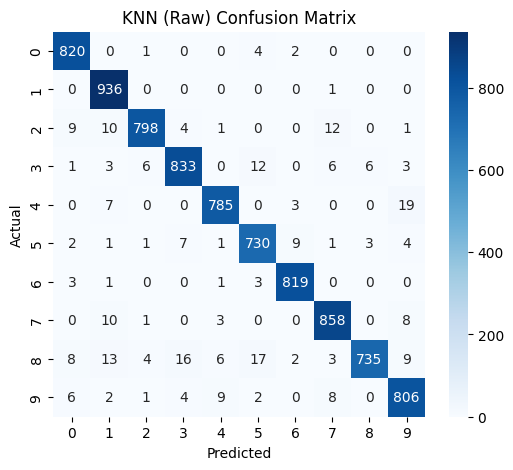

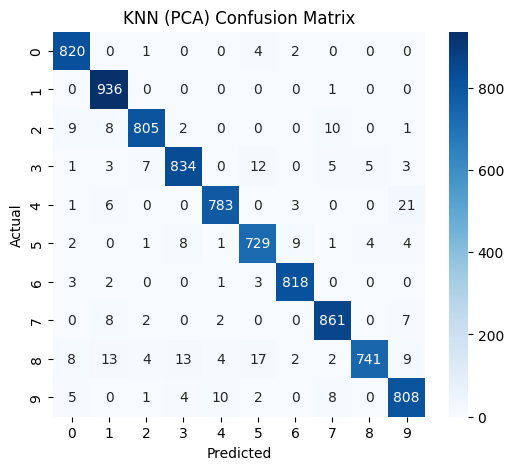

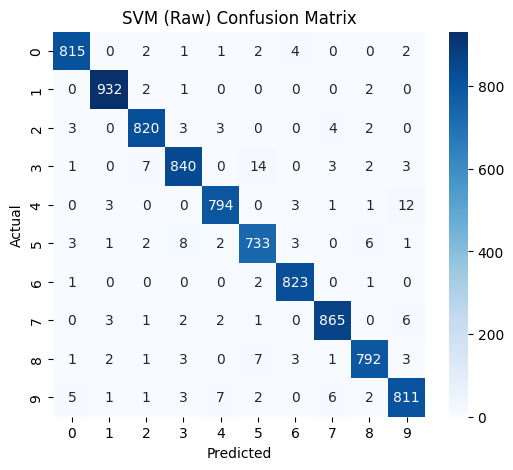

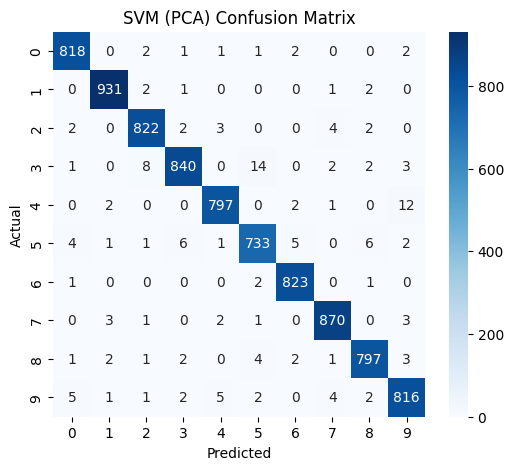

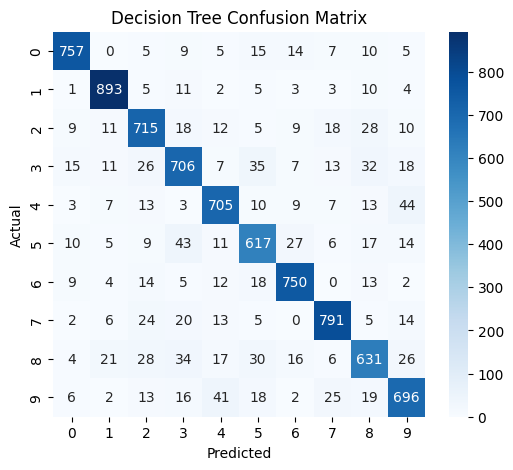

In [104]:
plot_confusion(y_test, y_pred_knn_raw, "KNN (Raw) Confusion Matrix")
plot_confusion(y_test, y_pred_knn_pca, "KNN (PCA) Confusion Matrix")
plot_confusion(y_test, y_pred_svm_raw, "SVM (Raw) Confusion Matrix")
plot_confusion(y_test, y_pred_svm_pca, "SVM (PCA) Confusion Matrix")
plot_confusion(y_test, y_pred_dt, "Decision Tree Confusion Matrix")

In [105]:
#misclassified image visualization for SVM with PCA

mis_idx = np.where(y_pred_svm_pca != y_test)[0][:10]

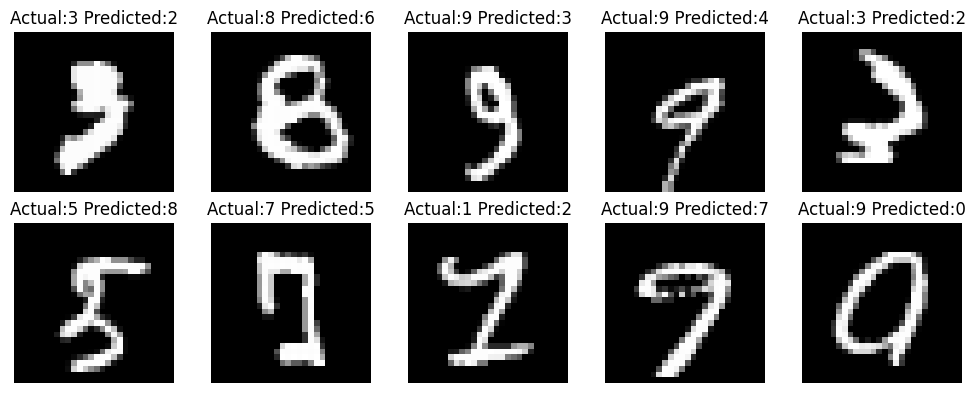

In [107]:
plt.figure(figsize=(10,4))

for i, idx in enumerate(mis_idx):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx].reshape(28,28), cmap="gray")
    plt.title(f"Actual:{y_test[idx]} Predicted:{y_pred_svm_pca[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Main reason of misclassification seems like similarity between digits. In the above misclassified images we can actually see some images which are very similar to two digits.

In [109]:
#Implementation of KNN without using any library(from scratch)

def knn_predict(X_train, y_train, x_test, k=3):
    distances = np.linalg.norm(X_train - x_test, axis=1)
    k_idx = np.argsort(distances)[:k]
    k_labels = y_train[k_idx]
    return Counter(k_labels).most_common(1)[0][0]

In [110]:
preds = []
for i in range(100):
    preds.append(knn_predict(X_train[:2000], y_train[:2000], X_test[i], k=3))

acc_knn_scratch = np.mean(preds == y_test[:100])
print("KNN from scratch accuracy (sampled):", acc_knn_scratch)

KNN from scratch accuracy (sampled): 0.9


I implemented it using Euclidean distance and majority voting over sampled dataset.

In [112]:
#bonus task - implement a voting ensemble
ensemble = VotingClassifier(
    estimators=[
        ("knn", knn_raw),
        ("svm", svm_raw),
        ("dt", dt_raw)
    ],
    voting="hard"
)

ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('svm', SVC(C=10)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=20,
                                                     random_state=42))])

In [114]:
y_pred_ens = ensemble.predict(X_test)

In [115]:
acc_ens = accuracy_score(y_test, y_pred_ens)
print("Voting Ensemble accuracy:", acc_ens)

Voting Ensemble accuracy: 0.9728571428571429


Ensemble method didn't improve overall accuracy as SVM raw accuracy was better, this happened because every model had equal vote in ensemble learning and Decision tree model had a bad accuracy.

**Task - 5** Reporting

Among the three ML models we used - KNN, SVM and Decision Tree. SVM showed best results with an accuracy score of 0.9792 with raw features. KNN with raw features gave an accuracy score of 0.9667 meanwhile Decision tree's accuracy score was only 0.8644.

So, SVM on PCA extracted features performed the best because PCA removed all the bad features from the dataset which helped in increasing accuracy and efficiency. One more fact which can back this reasoning is that SVM on raw features had much more training time and less accuracy compared to SVM on PCA extracted features.

When I visualized some of the misclassified images, it was really visible that most of the misclassified digits were the ones which are similar to other digits too. For example - 4 and 9, 6 and 8 etc. The error is also due to different writing style due to which there is very minimal difference between two digits.

Performance can be improved by using weighted voting ensemble, using a better feature extraction model, more dimension reduction techniques and get a larger dataset.